# One-Way ANOVA

One-way Analysis of Variance (ANOVA) is a multiple comparison technique testing whether the means of 3 or more groups are different. The hypotheses are as follows.

- $H_0$ (null): There is no difference between the means; $\mu_1 = \mu_2 = \ldots = \mu_n$
- $H_a$ (alternative): There is at least one group mean that differs from the overall mean.

ANOVA uses the [F-test](https://en.wikipedia.org/wiki/F-test) for testing statistical significance, which measures the ratio of the variance between groups to the variance within groups. 

When there are only 2 groups, a [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) may be used instead. However, with comparing 3 or more groups, ANOVA should be used since it corrects for the [family-wise error rate](https://en.wikipedia.org/wiki/Family-wise_error_rate) FWER holding the probability of a Type I error steady no matter the number of comparisons. 

In this notebook, let's see how a 1-way ANOVA relates to regression problems.

## Data

Let's generate 50 samples from 3 different normal distributions. These normal distributions are defined as follows.

- $A \sim \mathcal{N} (0, 1)$
- $B \sim \mathcal{N} (1, 1)$
- $C \sim \mathcal{N} (1.5, 1)$

These groups are often called `treatments`.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(37)

n = 50

df = pd.concat([
    pd.DataFrame({'group': 'A', 'y': pd.Series(np.random.normal(0, 1, n))}),
    pd.DataFrame({'group': 'B', 'y': pd.Series(np.random.normal(1, 1, n))}),
    pd.DataFrame({'group': 'C', 'y': pd.Series(np.random.normal(1.5, 1, n))})
])

In [2]:
df.head()

,group,y
0,A,-0.054464
1,A,0.674308
2,A,0.346647
3,A,-1.300346
4,A,1.518512


## Means

You can see that the empirical means and standard deviations are close to the real ones, but not exactly.

In [3]:
df.groupby(['group']).agg(['mean', 'std'])

y          
           mean       std
group                    
A      0.139065  0.998983
B      0.982454  1.057929
C      1.552792  1.052197

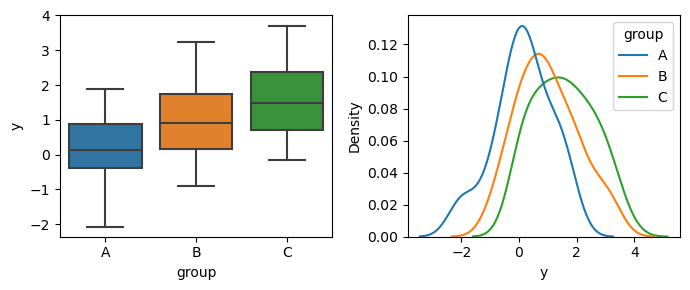

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

sns.boxplot(df, x='group', y='y', ax=ax[0])
sns.kdeplot(df, hue='group', x='y', ax=ax[1])

fig.tight_layout()

## t-test

Let's see what happens when we conduct all pairwise t-tests. You can see that group A is very different from B and C, but groups B and C are comparatively close.

In [5]:
from scipy import stats
import itertools

def do_test(pair):
    x, y = pair
    
    x = df[df['group']==x]['y']
    y = df[df['group']==y]['y']
    
    t = stats.ttest_ind(x, y)
    
    return {
        'x': pair[0],
        'y': pair[1],
        'statistic': t.statistic,
        'pvalue': t.pvalue
    }

t_test = itertools.combinations(df['group'].unique(), 2)
t_test = map(lambda tup: do_test(tup), t_test)
t_test = pd.DataFrame(t_test)
t_test

,x,y,statistic,pvalue
0,A,B,-4.098587,8.576614e-05
1,A,C,-6.889943,5.417835e-10
2,B,C,-2.702849,8.104302e-03


## 1-way ANOVA

Now we will apply a [1-way ANOVA](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html). The report F statistic and p-value are shown. The test would lead us to reject the null hypothesis.

In [6]:
F, p = stats.f_oneway(*[df[df['group']==g]['y'] for g in ['A', 'B', 'C']])

In [7]:
F

23.533902104682596

In [8]:
p

1.3590719185638985e-09

## Tukey's HSD

Here is a post-hoc test using [Tukey's Honestly Significant Difference test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.tukey_hsd.html). This test will see which two pair of groups are different.

In [9]:
hsd = stats.tukey_hsd(*[df[df['group']==g]['y'] for g in ['A', 'B', 'C']])

In [10]:
hsd.statistic

array([[ 0.        , -0.84338966, -1.41372695],
       [ 0.84338966,  0.        , -0.57033729],
       [ 1.41372695,  0.57033729,  0.        ]])

In [11]:
hsd.pvalue

array([[1.00000000e+00, 2.26787268e-04, 6.66437017e-10],
       [2.26787268e-04, 1.00000000e+00, 1.82679298e-02],
       [6.66437017e-10, 1.82679298e-02, 1.00000000e+00]])

In [12]:
hsd._nobs

3

In [13]:
hsd._ntreatments

150

In [14]:
hsd._stand_err

0.14661287403767

## Xy, means

Before we move onto regression, keep in mind the group means and overall mean.

In [15]:
df.groupby(['group']).agg(['mean', 'std'])

y          
           mean       std
group                    
A      0.139065  0.998983
B      0.982454  1.057929
C      1.552792  1.052197

In [16]:
df['y'].mean()

0.8914368828670105

## Regression

Here, we regress `y ~ g` but with g `dummy-encoded` (one-hot encoded). 

In [17]:
X = df.drop(columns=['y'])
y = df['y']

In [18]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(X)

OneHotEncoder()

In [19]:
X = pd.DataFrame(
    ohe.transform(X).todense(), 
    columns=ohe.get_feature_names_out()
)
X

,group_A,group_B,group_C
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
145,0.0,0.0,1.0
146,0.0,0.0,1.0
147,0.0,0.0,1.0
148,0.0,0.0,1.0


In [20]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X.drop(columns=['group_A']), y)

LinearRegression()

In [21]:
m.intercept_, m.coef_

(0.13906468043625642, array([0.84338966, 1.41372695]))

In [22]:
m.coef_

array([0.84338966, 1.41372695])

## Means vs coefficients

If you notice, the intercept of the regression model is the mean of A. If you add the coefficients to the intercept, you recover the means of B and C!

In [23]:
df.groupby(['group']).mean()

,y
group,
A,0.139065
B,0.982454
C,1.552792


In [24]:
m.intercept_, m.coef_ + m.intercept_

(0.13906468043625642, array([0.98245434, 1.55279163]))

## Test statistics vs coefficients

The coefficients are the test statistics Tukey's HSD!

In [25]:
hsd.statistic

array([[ 0.        , -0.84338966, -1.41372695],
       [ 0.84338966,  0.        , -0.57033729],
       [ 1.41372695,  0.57033729,  0.        ]])

In [26]:
m.coef_ 

array([0.84338966, 1.41372695])

When using Tukey's HSD, the p-values are given.

In [27]:
hsd.pvalue

array([[1.00000000e+00, 2.26787268e-04, 6.66437017e-10],
       [2.26787268e-04, 1.00000000e+00, 1.82679298e-02],
       [6.66437017e-10, 1.82679298e-02, 1.00000000e+00]])

We can also compute the p-values as below.

In [28]:
def get_se(df):
    '''
    Computes standard error. 
    Adapted from https://github.com/scipy/scipy/blob/v1.10.1/scipy/stats/_hypotests.py.
    When groups are unequal, this code should be adjusted too.
    '''
    _v = np.array([np.var(df[df['group']==g]['y'], ddof=1) for g in df['group'].unique()])
    _s = np.array([df[df['group']==g].shape[0] - 1 for g in df['group'].unique()])
    _n = df.shape[0] - df['group'].unique().shape[0]
    _mse = np.sum(_v * _s) / _n
    _norm = 2 / df[df['group']=='A'].shape[0]
    _se = np.sqrt(_norm * _mse / 2)
    
    return _se

def get_pvalue(m_0, m_1, se, k, dof):
    diff = np.abs(m_0 - m_1)
    t = diff / se
    print(f'{t=}, {k=}, {dof=}')
    return stats.distributions.studentized_range.sf(t, k, dof)

In [29]:
_mean = df.groupby(['group']).mean()['y'].to_numpy()
_se = get_se(df)
_k = df['group'].unique().shape[0]
_dof = df.shape[0] - _k

In [30]:
_mean

array([0.13906468, 0.98245434, 1.55279163])

In [31]:
_se

0.14661287403767

In [32]:
_k

3

In [33]:
_dof

147

In [34]:
get_pvalue(_mean[0], _mean[1], _se, _k, _dof)

t=5.752493850354061, k=3, dof=147


0.00022678726812552785

In [35]:
get_pvalue(_mean[0], _mean[2], _se, _k, _dof)

t=9.64258398375435, k=3, dof=147


6.664370166831191e-10

In [36]:
get_pvalue(_mean[1], _mean[2], _se, _k, _dof)

t=3.8900901334002893, k=3, dof=147


0.01826792981617653

Here's yet another way to compute the p-values.

In [37]:
1 - stats.studentized_range.cdf(np.abs(_mean[0] - _mean[1]) / _se, _k, _dof)

0.00022678726812552785

In [38]:
1 - stats.studentized_range.cdf(np.abs(_mean[0] - _mean[2]) / _se, _k, _dof)

6.664370166831191e-10

In [39]:
1 - stats.studentized_range.cdf(np.abs(_mean[1] - _mean[2]) / _se, _k, _dof)

0.01826792981617653

## Contrast coding

In [40]:
X = df.assign(
    AB=lambda d: np.select([d['group']=='A', d['group']=='B'], [-0.5, 0.5], default=0.0),
    AC=lambda d: np.select([d['group']=='A', d['group']=='C'], [-0.5, 0.5], default=0.0)
)[['AB', 'AC']]

y = df['y']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(0.8914368828670105, array([0.18203491, 1.3227095 ]))

In [41]:
X = df.assign(
    AvB=lambda d: np.select([d['group']=='A', d['group']=='B'], [-0.5, 0.5], default=0.0),
    ABvC=lambda d: np.select([d['group']=='C'], [0.5], default=-0.5)
)[['AvB', 'ABvC']]

y = df['y']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(1.0567755700112798, array([0.84338966, 0.99203212]))

In [42]:
X = df.assign(
    AvB=lambda d: np.select([d['group']=='A', d['group']=='B'], [-0.5, 0.5], default=0.0),
    ABvC=lambda d: np.select([d['group']=='C'], [0.5], default=-0.25)
)[['AvB', 'ABvC']]

y = df['y']

m = LinearRegression()
m.fit(X, y)

m.intercept_, m.coef_

(0.8914368828670105, array([0.84338966, 1.3227095 ]))